In [1]:
from utils.CoopEnv import CoopEnv
from utils.IACagent import Agent

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import tensorflow as tf

In [3]:
# Set constant hyperparameters
n = 40
num_of_tasks  = 22
num_of_sims = 1
step_limit = 10000

In [4]:
move_space = num_of_tasks

lower_bound = -.99
upper_bound = 2
comm_array = np.arange(start=lower_bound, stop=upper_bound+0.01, step=0.01)

comm_space = len(comm_array)
print(comm_space)

300


In [5]:
env = CoopEnv(n=n, num_of_tasks=num_of_tasks)

In [6]:
steps_to_complete = np.zeros((num_of_sims, step_limit+1))
comm_rec_actions = np.zeros((step_limit, env.n))
move_rec_actions = np.zeros((step_limit, env.n))

In [7]:
def main():

    for s in range(num_of_sims):

        print("----------------------------------")
        print(f"Starting training simulation {s}:")
        print("----------------------------------")

        # reinitialise agent list each sim
        agentlist = {i: Agent(move_space, comm_space) for i in range(env.n)}
        # reset the environment
        observations = env.reset(n=n, num_of_tasks =num_of_tasks )

        # begin training loop
        t = 0
        while t < step_limit:
            print(t, end='\r')
            sys_actions = np.zeros((env.n, 2)) # column 0 for move actions and column 1 for comm actions
            # collect move and comm  action for each agent
            sys_actions = np.array([agentlist[i].choose_action(observations[i]) for i in range(env.n)])

            action_move = sys_actions[:,0]
            action_comm = comm_array[sys_actions[:,1]]

            next_observations, rewards, termination, info = env.step(action_move, action_comm) # env.step

            comm_rec_actions[t] = action_comm  # output from actor (comm head)
            move_rec_actions[t] = action_move

            for C in env.CS: # train each agent

                if len(C)>0:

                    acc_grad_actor = [tf.zeros_like(t) for t in agentlist[0].aModel.trainable_variables]
                    acc_grad_critic = [tf.zeros_like(t) for t in agentlist[0].vModel.trainable_variables]
                    agent_indices = [int(a)-1 for a in list(C)]

                    for i in agent_indices:
                        grad_actor, grad_critic = agentlist[i].train(observations[i], sys_actions[i, :], rewards[i], next_observations[i])

                        for j in range(len(acc_grad_actor)):
                            acc_grad_actor[j] += grad_actor[j]/len(C)

                        for j in range(len(acc_grad_critic)):
                            acc_grad_critic[j] += grad_critic[j]/len(C)

                    # Check numerical stability
                    for grad in acc_grad_actor:
                        if tf.math.reduce_any(tf.math.is_nan(grad)) or tf.math.reduce_any(tf.math.is_inf(grad)):
                            raise ValueError(f"NaNs or infs in actor gradient. Stopping training.")
                    for grad in acc_grad_critic:
                        if tf.math.reduce_any(tf.math.is_nan(grad)) or tf.math.reduce_any(tf.math.is_inf(grad)):
                            raise ValueError(f"NaNs or infs in critic gradient. Stopping training.")


                    for i in agent_indices:

                        agentlist[i].update(acc_grad_actor, acc_grad_critic)

            # advance state
            observations = next_observations
            # record average system reward score
            steps_to_complete[s, t+1] = (sum(rewards)/env.n) + steps_to_complete[s, t]

            # increment timestep and loop
            t +=1




In [8]:
if __name__ == "__main__":

    #cProfile.run('main()')
    main()


----------------------------------
Starting training simulation 0:
----------------------------------


KeyboardInterrupt: 

In [ ]:
np.save(f'n{n}t{num_of_tasks}_cum_rew_[{lower_bound},{upper_bound}]', steps_to_complete)
np.save(f'n{n}t{num_of_tasks}_actions_[{lower_bound},{upper_bound}]', comm_rec_actions)

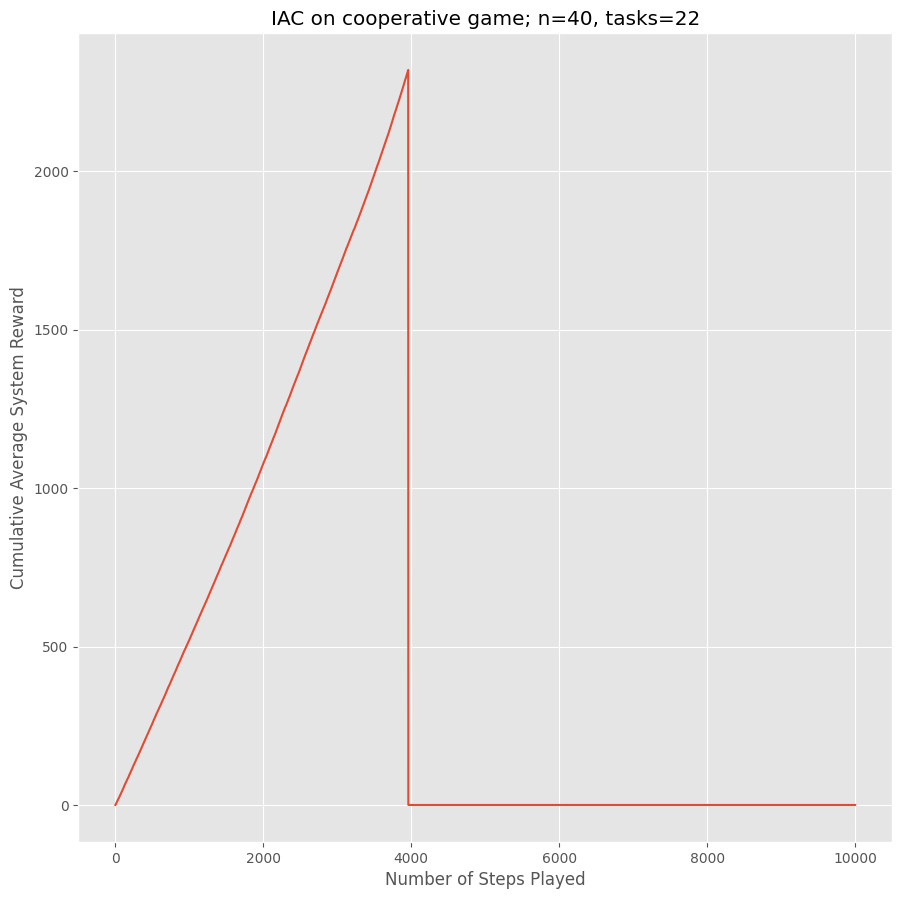

In [ ]:
plt.style.use('ggplot')
b = np.mean(steps_to_complete, axis=0)
s_dev = np.std(steps_to_complete, axis=0)
plt.xlabel('Number of Steps Played')
plt.ylabel('Cumulative Average System Reward')
plt.title(f'IAC on cooperative game; n={n}, tasks={num_of_tasks}')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.plot(b)

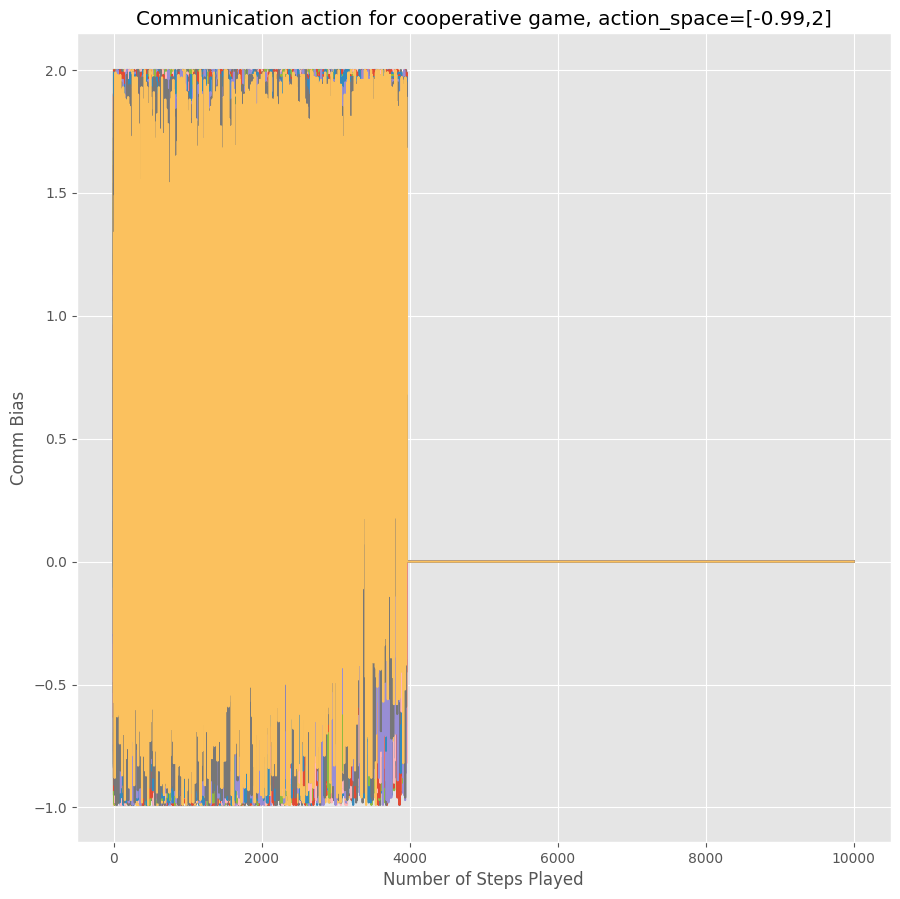

In [ ]:
plt.xlabel('Number of Steps Played')
plt.ylabel('Comm Bias')
plt.title(f'Communication action for cooperative game, action_space=[{lower_bound},{upper_bound}]')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)

plt.plot(comm_rec_actions)

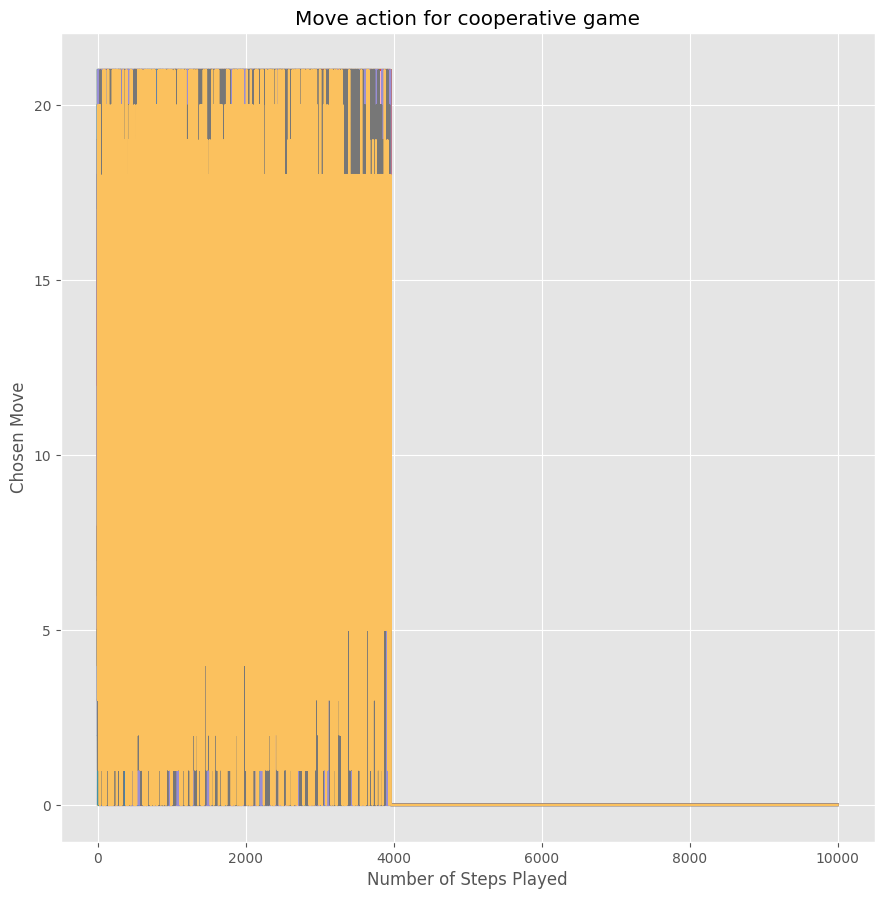

In [ ]:
plt.xlabel('Number of Steps Played')
plt.ylabel('Chosen Move')
plt.title(f'Move action for cooperative game')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)

plt.plot(move_rec_actions)

In [ ]:
# Get coalition structure
print(env.CS)


[set(), set(), {'9'}, {'24', '25'}, set(), {'3'}, {'8', '5', '28', '11', '4', '14'}, {'12', '16'}, {'37', '21', '18'}, {'20', '32', '17'}, {'6'}, set(), {'38', '35'}, set(), {'10', '31', '39', '1', '27', '2', '19'}, set(), {'40', '13', '22'}, {'7'}, {'30'}, {'33', '15', '29', '26'}, {'23'}, {'36', '34'}]


In [ ]:
print(comm_rec_actions[3959])
print(move_rec_actions[3959])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
